# In-depth example

In this notebook we will be going through an example of running ``imcascade`` in a realistic setting and discussing issues along the way

In [1]:
#Load all neccesary packages
import numpy as np
import matplotlib.pyplot as plt
import time
import sep

import astropy.units as u
from astropy.coordinates import SkyCoord

For this example we will be running ``imcascade`` on HSC data on a MW mass galaxy at z=0.25. The data is attained in the cell below and is retrieved using the ``unagi`` python package availible [here](<https://github.com/dr-guangtou/unagi) , written by Song Huang. The cell below is used to download the data and the PSF

In [2]:
from unagi import hsc
from unagi.task import hsc_psf,hsc_cutout
pdr2 = hsc.Hsc(dr='pdr2',rerun = 'pdr2_wide')

#Downloaded from HSC archive, this a MW mass galaxy at z~0.25 at the sky location below
ra,dec = 219.36054754*u.deg, -0.40994375*u.deg
examp_coord = SkyCoord(ra = ra, dec = dec)
cutout = hsc_cutout(examp_coord, cutout_size=20*u.arcsec, filters='i', archive = pdr2, dr = 'pdr2', verbose=True, variance=True, mask=True, save_output = False)
psf = hsc_psf(examp_coord, filters='i', archive=pdr2, save_output = False)

#Retrieve science and variance images
img = cutout[1].data.byteswap().newbyteorder()
var = cutout[3].data.byteswap().newbyteorder()
psf_data = psf[0].data

# Get table list from /home/tim/anaconda3/envs/imc/lib/python3.9/site-packages/unagi/data/pdr2_wide/pdr2_wide_tables.fits
# Retrieving cutout image in filter: i
# Retrieving coadd PSF model in filter: i


## Setting up

### Modelling the PSF

To use ``imcascade`` while accounting for the PSF, you need to have a Gaussian decomposition of the PSF. While this is availible for some surveys, you can use the ``imcascade.psf_fitter`` module to help if you have a pixelized version.

The following function first fits the PSF profile in 1D to decide what the best widths are. Then a 2D fit is used to find the correct weights

[1.56676938 3.1562418  7.16928138] [0.72289466 0.21654144 0.05830564]


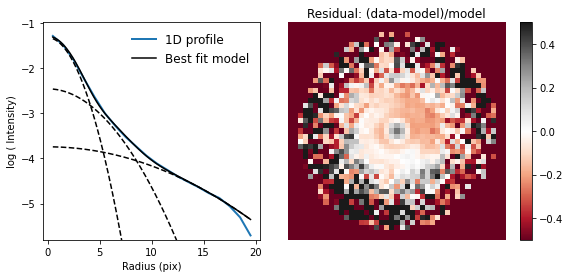

In [3]:
from imcascade.psf_fitter import PSFFitter
psf_fitter = PSFFitter(psf_data)
psf_sig,psf_a,chi2, fig = psf_fitter.fit_N(3, plot = True) # Can choose number
print (psf_sig,psf_a)
plt.show()

We can see that a model with three gaussians provides a pretty good fit! Generally we find 2-3 components works well for standard ground based telescopes and for more complicated PSFs, like HST WFC3, we find 4 works well. There is some incentive to use a small number of gaussians to define the PSF as it decreasese the time to render a model image. Additionally it is good to check that the sum of the weights, ``psf_a``, is close to one. This ensures the PSF, and the fit are properly normalized

### Organizing all the inputs

First let's take a quick look at the science and variance images. We will be fitting a model to the science image and the inverse of the variance image will be used as the pixel weights when fitting

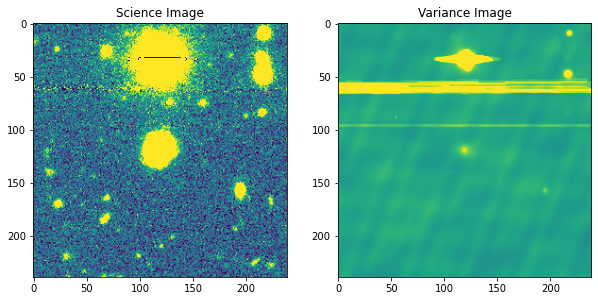

In [4]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (10,5))
ax1.imshow(img, vmin = -0.1, vmax = 0.2)
ax1.set_title('Science Image')
ax2.imshow(var,vmin = 0, vmax = 0.005)
ax2.set_title('Variance Image')
plt.show()

Additionally we will be building a mask to mask contaminating sources that we don't want affecting the fit

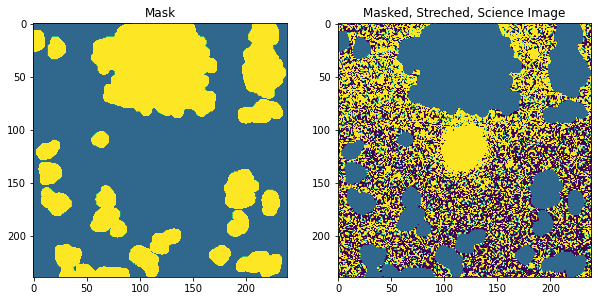

In [5]:
# Use sep to detect sources
bkg = sep.Background(img)
x_cent,y_cent = int(img.shape[0]/2.) , int(img.shape[1]/2.)
obj,seg = sep.extract(img - bkg.back(), 1.5, err = np.sqrt(var), deblend_cont = 0.005,segmentation_map = True)
seg[np.where(seg == seg[x_cent,y_cent])] = 0
mask_raw = seg > 0

#Convolve mask with a gaussian to expand it and make sure that all low-SB emission is masked
from imcascade.utils import expand_mask
mask = expand_mask(mask_raw, radius = 1.5)
mask = np.array(mask, dtype = bool)


fig, (ax1,ax2) = plt.subplots(1,2, figsize = (10,5))
ax1.imshow(mask, vmin = -0.1, vmax = 0.2)
ax1.set_title('Mask')
ax2.imshow(img*np.logical_not(mask),vmin = -0.01, vmax = 0.02)
ax2.set_title('Masked, Streched, Science Image')
plt.show()

### Choosing the widths for the Gaussian components

The next major decision is what set of widths to use for the Gaussian components. In general we reccomend logarithmically spaced widths. This means there are more components are smaller radii where the signal is the largest and the profile changes the quickest. asinh scaling can also work. 

Next we have to choose start and end points. This should be 0.5-1 pixel (or half the PSF width) to roughly 10 times the effective radius. The estimate of the effective radius does not need to be accurate, for example the Kron radius for sep or Sextractor works well. This should help decide the size of the cutout too. In order to properly model the sky the cutoutsize should be at least 3-4 times larger then the largest width, so 30-40 times the effective radius.

Finally we have to choose the number of components. In our testing somewhere around 9-11 seems to work.

.. note::
These decisions are not trivial and can affect on the outcome of an ``imcascade`` fit. However reasonable changes withn the confines discussed here shouldn't greatly affect the results. You should run tests to ensure you have chosen a reliable set of widths. If the results are very sensitive to the choice of widths, you should be wary and there may be other issues at play.

In this example we estimate the effective radius to be roughly 6 pixels so we use 9 components with logarithmically spaced widths from 1 pixels to 60 pixels (~10 x r eff) and use a cutout size of 240 pixels, roughly 40 times the effective radius.

In [6]:
sig = np.logspace(np.log10(1),np.log10(60), num = 9)

We can also specify inital conditions to help make inital guesses. Here we specify the estimated half light radii and total flux. The code make some intelligent guesses on the inital conditions and the bounds but this may help ensure a quick and reliable fit. It is also possible to specify guessea and bounds for individual components, sky values etc. but this is more involved. See the user's guide for more details

In [7]:
init_dict  = {'re':6., 'flux': 1000.}

## Running ``imcascade``

### Least squares-minimization

To run imcascade we first need to intialize a ``Fitter`` instance with all the inputs discussed above. This class organizes all the data and contains all the methods used to fit the image

In [8]:
from imcascade import Fitter
fitter = Fitter(img,sig, psf_sig, psf_a, weight = 1./var, mask = mask, init_dict = init_dict)

Now we can run least squares minimization using the command below

In [9]:
min_res = fitter.run_ls_min()

2021-05-13 20:36:43,157 - Running least squares minimization
2021-05-13 20:38:30,496 - Finished least squares minimization


<ipython-input-10-0baef58ef498>:11: RuntimeWarning: divide by zero encountered in log10
  ax1.imshow(np.log10(fitter.img*np.logical_not(mask)),vmin = -2, vmax =1)
<ipython-input-10-0baef58ef498>:11: RuntimeWarning: invalid value encountered in log10
  ax1.imshow(np.log10(fitter.img*np.logical_not(mask)),vmin = -2, vmax =1)
<ipython-input-10-0baef58ef498>:13: RuntimeWarning: invalid value encountered in log10
  ax2.imshow(np.log10(best_fit_mod),vmin = -2, vmax =1)


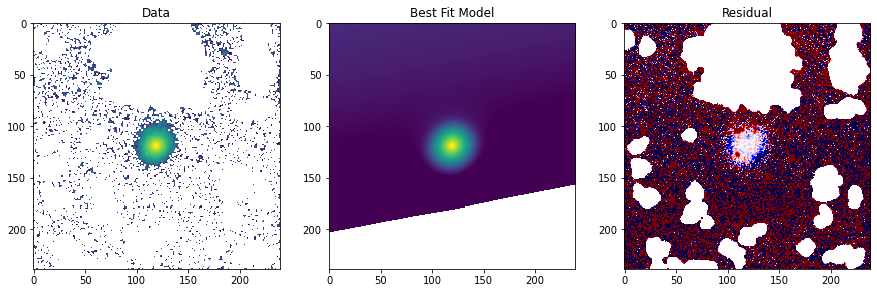

In [10]:
## Let's take a quick look at the best fit-model to make sure it looks god
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize = (15,5))

best_fit_mod = fitter.make_model(min_res.x) #generate a model image using the best fitting parameters

#Calculate the residual image and mask out the other sources
resid = (fitter.img - best_fit_mod)/best_fit_mod
resid *= np.logical_not(fitter.mask)

ax1.set_title('Data')
ax1.imshow(np.log10(fitter.img*np.logical_not(mask)),vmin = -2, vmax =1)
ax2.set_title('Best Fit Model')
ax2.imshow(np.log10(best_fit_mod),vmin = -2, vmax =1)
ax3.set_title('Residual')
ax3.imshow(resid, vmin = -0.5, vmax = 0.5, cmap = 'seismic')
#ax3.set_xlim([50,150])
#ax3.set_ylim([150,50])

plt.show()

While there are some asymmetric features that can't be described by axisymmetric model the fit overall looks pretty good.

The best fit parameters can be also be accessed,

In [17]:
fitter.min_res.x

array([ 1.20223935e+02,  1.18955020e+02,  9.11389736e-01,  2.29045943e+00,
        2.20705720e+00, -1.99999780e+00,  2.13000341e+00,  2.55817400e+00,
        2.85057953e+00, -1.99999911e+00,  1.45816601e+00, -1.99999969e+00,
       -1.99999998e+00,  7.07456398e-03, -1.16053899e-04, -2.28207981e-05])

They are, in order, $x_0$,$y_0$, axis ratio and position angle. Than the next 9 values are the best fit weights for the Gaussian components. Note that by default ``imcascade`` explores these in log scale. This can be changes by passing the option ``log_weight_scale = False`` when intializing. The final three parameters describe the best fit tilted-plane sky model. The can also be disabled when intializing with ``sky_model = False``.

These aren't super easy to parase as is, which is why we using the ``ImcascadeResults`` class discussed below.

### Bayesian inference
Below we show the commands that could be used to run Bayesian inference. Here we are using the `express` method based on pre-rendered images. There are additional options when running ``dynesty`` using ``imcascade``. Specifically we offer two choices of priors, the default is based on the results of the least-squares minimization, the other being uniform priors. We found the former runs quicker and more reliably as the priors are not as broad. It is also possible to set you own priors, see the Advanced section for more details.

.. code-block:: python

  fitter.run_dynesty(method = 'express')
  fitter.save_results('./examp_results.asdf', run_basic_analysis = False)

This is much quicker than the traditional method. However it still took about 30 min to run on my laptop. So I have run it previously and we will load the saved data.

## Analyzing the results

Since when using ``imcascade`` the paramters that are fit are the fluxes of each Gaussian component, the analysis is more involved then other parameterized models, which fit directly for the total flux, radius etc. To assist in this we have written the ``results`` module and the ``ImcascadeResults`` class. This class can be initialized multiple ways. First you can pass it a ``Fitter`` instance after running ``run_ls_min()`` and/or ``run_dynesty()``. Alternatively it can be passed a string which denotes the location of an ASDF file of the saved results

In [11]:
from imcascade import ImcascadeResults

#Initialized using fitter instance
ls_res = ImcascadeResults(fitter)

#Initialized with saved file
dyn_res = ImcascadeResults('examp_results.asdf')

``ImcascadeResults`` will default to using the posterior to derrive morphological parameters if it is availible. For ``ls_res`` since we did not run any bayesian method, it will use the best fit parameters. Note that without a bayesian method no measurement errors will be displayed. 

There are a number of functions we have written to calculate various morpological quantities, please see the API reference for all functions. For a lot of applications, one can simple run ``run_basic_analysis()`` which calculates a series of common morpological quantities

In [12]:
#For ls_res we can see there are no error bars. By specifying a zpt, we can also calculate the total magnitude
ls_res.run_basic_analysis(zpt = 27)

{'flux': 1395.1876996629685,
 'mag': 19.138418403118877,
 'r20': 2.456984739872308,
 'r50': 6.239519164395292,
 'r80': 11.467785253840017,
 'r90': 14.788535289120016,
 'C80_20': 4.667422254497197,
 'C90_50': 2.3701402142505095}

In [13]:
#we can also specify the percentiles used to calculate the error bars, here we use the 5th-95th percentile
dyn_res.run_basic_analysis(zpt = 27, errp_lo = 5, errp_hi = 95) 

{'flux': array([1392.29598627,    7.78567762,    8.19996072]),
 'mag': array([1.91406711e+01, 6.37571292e-03, 6.08844357e-03]),
 'r20': array([2.45204514, 0.01664059, 0.01731346]),
 'r50': array([6.22609692, 0.03780477, 0.03971284]),
 'r80': array([11.42816133,  0.10914675,  0.11617468]),
 'r90': array([14.71305841,  0.21685708,  0.2334946 ]),
 'C80_20': array([4.66072506, 0.02801944, 0.02844901]),
 'C90_50': array([2.36328208, 0.02271715, 0.02335112])}

In addition to these integrated  quantities, we can calculate the surface brightness profile and curve-of-growth as a function of semi-major axis

In [14]:
#Sets of radii to calculate profiles at
rplot = np.linspace(0, 50, num = 200)

sbp_ls_tot = ls_res.calc_sbp(rplot)

# Using return_ind we return the contributions of each individual gaussian component
sbp_ls_ind = ls_res.calc_sbp(rplot,return_ind = True)

If you use ``dyn_res`` where the postior distribution is availible it will return a 2D array containing the SBP of each sample of the posterior.

In [15]:
#Here we will calculate the posterier distribution of the surface_brightness profile
sbp_all = dyn_res.calc_sbp(rplot)
print (sbp_all.shape)

#Here we calculate the curve-of-growth for the posterier
cog_all = dyn_res.calc_cog(rplot)

(200, 25970)


Now we plot both, the red lines show the individual components from the least squares solution and all the black lines show individual samples from the posterior

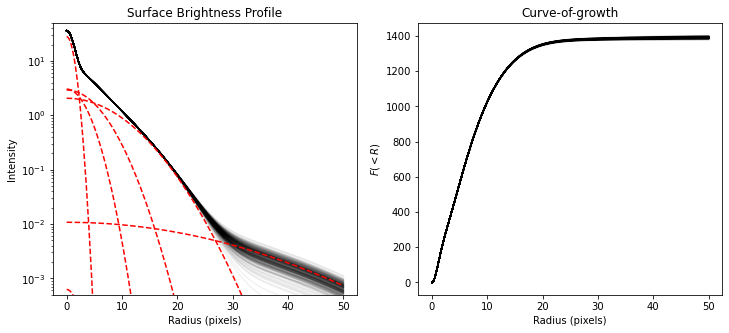

In [16]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (12,5))
ax1.plot(rplot, sbp_all[:,::100], 'k-', alpha = 0.05)
ax1.plot(rplot, sbp_ls_ind, 'r--', alpha = 1.)

ax1.set_yscale('log')
ax1.set_ylim([5e-4,5e1])
ax1.set_title('Surface Brightness Profile')
ax1.set_xlabel('Radius (pixels)')
ax1.set_ylabel('Intensity')

ax2.plot(rplot,cog_all[:,::100], 'k-', alpha = 0.05)
ax2.set_title('Curve-of-growth')
ax2.set_xlabel('Radius (pixels)')
ax2.set_ylabel(r'$F(<R)$')
plt.show()

If you are interested in morphological quantity that is not included, it is likely that it will be easy to calculate and code up, so please contact us!